In [85]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from pydensecrf import densecrf
from pydensecrf.utils import unary_from_labels
from models.batchLoader import BatchLoader
%matplotlib inline

In [86]:
batch_size = 10
#image_folder = 's2cloudless_imagery'
image_folder = 'nwpu_images'
image_size = (256, 256)
images = glob.glob(os.path.join(image_folder, 'data', '*.jpg'))
#mask_folder = 's2cloudless_label_imagery'
mask_folder = 'nwpu_label_images'

In [87]:
def crf_labelrefine(input_image, predicted_labels):
    compat_spat = 10
    compat_col = 30
    theta_spat = 20
    theta_col = 80
    num_iter = 7
    num_classes = 2
    h, w = input_image.shape[:2]
    d = densecrf.DenseCRF2D(w, h, 2)
    predicted_unary = unary_from_labels(predicted_labels.astype('int')+1, num_classes, gt_prob= 0.51)
    d.setUnaryEnergy(predicted_unary)
    d.addPairwiseGaussian(sxy=(theta_spat, theta_spat), compat=compat_spat, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)
    input_image_uint = (input_image * 255).astype(np.uint8) #enfore unsigned 8-bit
    d.addPairwiseBilateral(sxy=(theta_col, theta_col), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=compat_col, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)
    refined_predictions = np.array(d.inference(num_iter)).reshape(num_classes, h, w)
    return np.argmax(refined_predictions,axis=0)

Create a batch loader object by instantiating the `BatchLoader` class.

In [88]:
batch_loader = BatchLoader(images, image_folder, mask_folder, batch_size, image_size)
batch_generator = batch_loader()

In [89]:
x, y = next(batch_generator)

Display the shape of the pair image and mask to verify its dimensions.

In [90]:
print("image batch size: ", x.shape)
print("mask batch size: ", y.shape)

image batch size:  (10, 256, 256, 3)
mask batch size:  (10, 256, 256, 1)


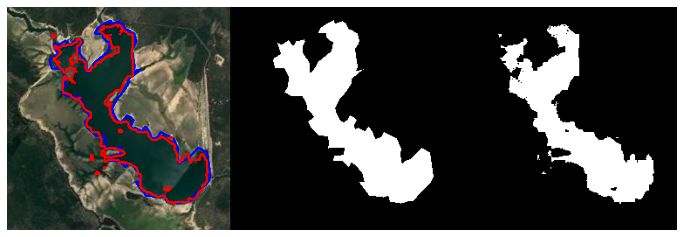

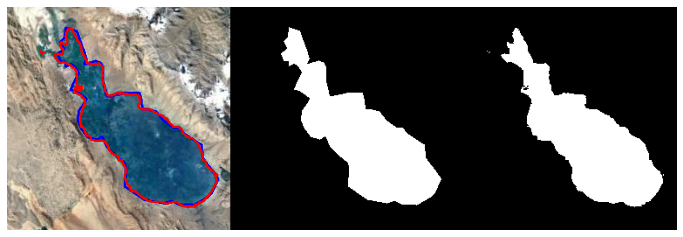

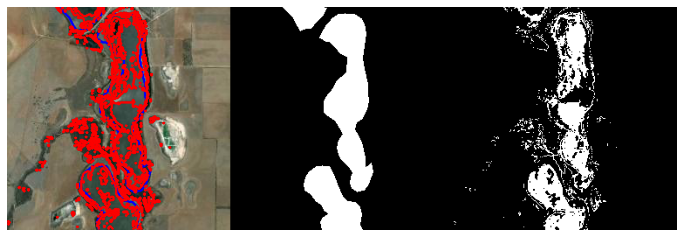

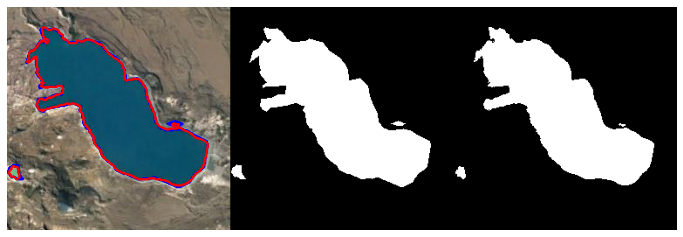

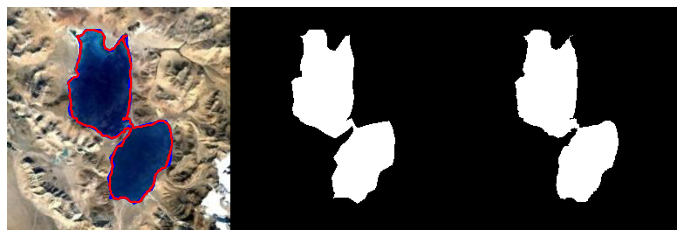

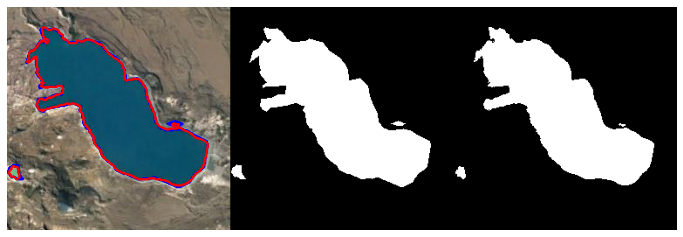

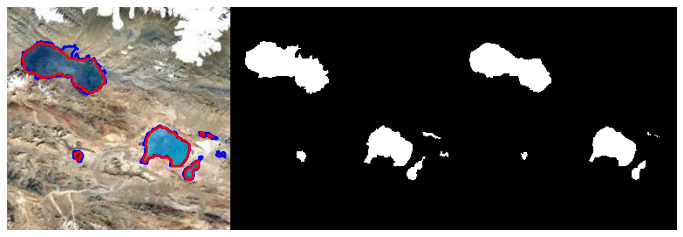

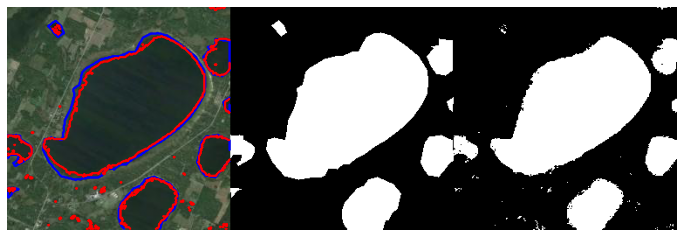

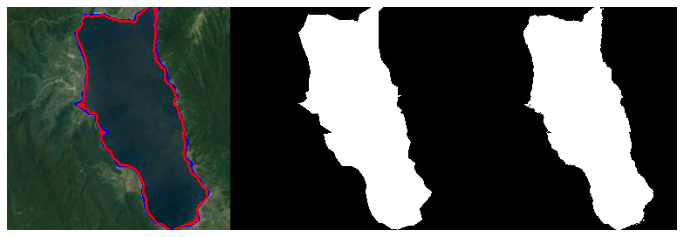

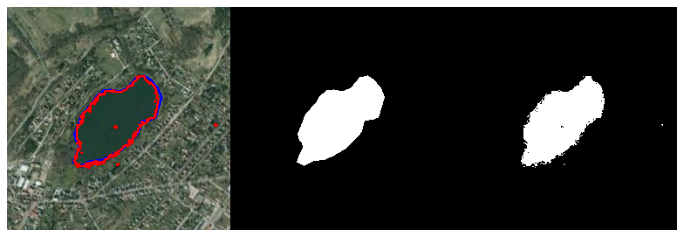

In [95]:
for i in range(batch_size):
    plt.figure(figsize=(12,6))
    plt.axis('off')
    image = x[i]
    mask = y[i].squeeze()
    plt.contour(mask, alpha=0.5, colors='b')
    crf = crf_labelrefine(x[i], mask)
    plt.contour(crf, alpha=0.5, colors='r')
    mask = np.stack((mask,) * 3, axis=-1)
    crf = np.stack((crf,) * 3, axis=-1)
    pair = np.concatenate([image, mask, crf], axis=1)
    plt.imshow(pair)